qwen2.5-vl的grounding推理

In [1]:
import json
import random
import io
import ast
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor
import xml.etree.ElementTree as ET

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def decode_xml_points(text):
    try:
        root = ET.fromstring(text)
        num_points = (len(root.attrib) - 1) // 2
        points = []
        for i in range(num_points):
            x = root.attrib.get(f'x{i+1}')
            y = root.attrib.get(f'y{i+1}')
            points.append([x, y])
        alt = root.attrib.get('alt')
        phrase = root.text.strip() if root.text else None
        return {
            "points": points,
            "alt": alt,
            "phrase": phrase
        }
    except Exception as e:
        print(e)
        return None

def plot_bounding_boxes(im, bounding_boxes, input_width, input_height):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

    try:
      json_output = ast.literal_eval(bounding_boxes)
    except Exception as e:
      end_idx = bounding_boxes.rfind('"}') + len('"}')
      truncated_text = bounding_boxes[:end_idx] + "]"
      json_output = ast.literal_eval(truncated_text)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json_output):
      # Select a color from the list
      color = colors[i % len(colors)]

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["bbox_2d"][1]/input_height * height)
      abs_x1 = int(bounding_box["bbox_2d"][0]/input_width * width)
      abs_y2 = int(bounding_box["bbox_2d"][3]/input_height * height)
      abs_x2 = int(bounding_box["bbox_2d"][2]/input_width * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
      )

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    # Display the image
    img.show()


def plot_points(im, text, input_width, input_height):
  img = im
  width, height = img.size
  draw = ImageDraw.Draw(img)
  colors = [
    'red', 'green', 'blue', 'yellow', 'orange', 'pink', 'purple', 'brown', 'gray',
    'beige', 'turquoise', 'cyan', 'magenta', 'lime', 'navy', 'maroon', 'teal',
    'olive', 'coral', 'lavender', 'violet', 'gold', 'silver',
  ] + additional_colors
  xml_text = text.replace('```xml', '')
  xml_text = xml_text.replace('```', '')
  data = decode_xml_points(xml_text)
  if data is None:
    img.show()
    return
  points = data['points']
  description = data['phrase']

  font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

  for i, point in enumerate(points):
    color = colors[i % len(colors)]
    abs_x1 = int(point[0])/input_width * width
    abs_y1 = int(point[1])/input_height * height
    radius = 2
    draw.ellipse([(abs_x1 - radius, abs_y1 - radius), (abs_x1 + radius, abs_y1 + radius)], fill=color)
    draw.text((abs_x1 + 8, abs_y1 + 6), description, fill=color, font=font)
  
  img.show()
  

# @title Parsing JSON output
def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

In [2]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
# model_path = "/data/guojian.li/Weight/Qwen2.5-VL-7B-Instruct"
model_path = "/data/guojian.li/Project/Video-R1/src/r1-v/log/Qwen2.5-VL-7B-sarcasm-sft"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(model_path, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2",device_map=device)
processor = AutoProcessor.from_pretrained(model_path)

/opt/conda/envs/video-r1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-06-24 17:23:06,433] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
def inference(img_url, prompt, system_prompt="You are a helpful assistant", max_new_tokens=1024):
  image = Image.open(img_url)
  messages = [
    {
      "role": "system",
      "content": system_prompt
    },
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": prompt
        },
        {
          "image": img_url
        }
      ]
    }
  ]
  text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
  print("input:\n",text)
  inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt").to('cuda:1')

  output_ids = model.generate(**inputs, max_new_tokens=1024)
  generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
  output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
  print("output:\n",output_text[0])

  # 在源码处理中，除以了patch大小，这里需要乘回来
  input_height = inputs['image_grid_thw'][0][1]*14
  input_width = inputs['image_grid_thw'][0][2]*14

  return output_text[0], input_height, input_width

In [32]:
image_path = "./data/1.png"


## Use a local HuggingFace model to inference.
# prompt in chinese
# prompt in english
prompt = "我将会给你一个bbox坐标[x1,y1,x2,y2]，请你告诉我这个坐标对应的物体是什么？\n坐标是[1022, 54, 1232, 225]。"
response, input_height, input_width = inference(image_path, prompt)
print("input_height:", input_height)
print("input_width:", input_width)
print("response:", response)
image = Image.open(image_path)
# print(image.size)
# image.thumbnail([640,640], Image.Resampling.LANCZOS)
# plot_bounding_boxes(image,prompt,input_width,input_height)

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
我将会给你一个bbox坐标[x1,y1,x2,y2]，请你告诉我这个坐标对应的物体是什么？
坐标是[1022, 54, 1232, 225]。<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

output:
 根据你提供的bbox坐标[1022, 54, 1232, 225]，该区域对应的是一个插座。
input_height: tensor(868, device='cuda:1')
input_width: tensor(1232, device='cuda:1')
response: 根据你提供的bbox坐标[1022, 54, 1232, 225]，该区域对应的是一个插座。


input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
框出所有物体的坐标，以json格式输出所有的坐标<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

output:
 ```json
[
    {"bbox_2d": [0, 168, 705, 734], "label": "装有面粉的大碗"},
    {"bbox_2d": [112, 54, 752, 439], "label": "装有鸡蛋的纸盒"},
    {"bbox_2d": [702, 244, 1223, 690], "label": "带刻度的量杯"},
    {"bbox_2d": [0, 34, 188, 225], "label": "金属罐子"},
    {"bbox_2d": [1022, 54, 1232, 225], "label": "电源插座"}
]
```
(1246, 864)
(640, 444)


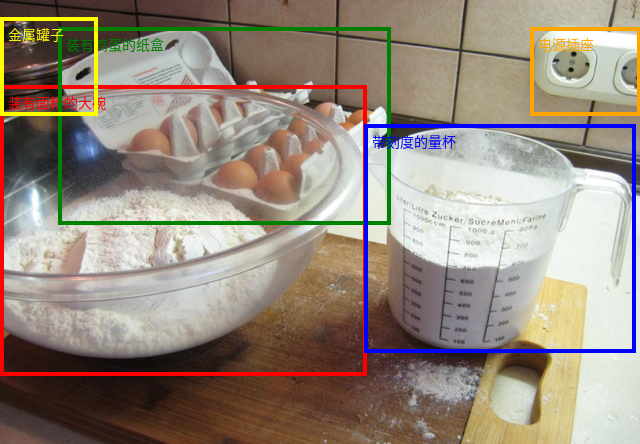

In [31]:
image_path = "./data/1.png"


## Use a local HuggingFace model to inference.
# prompt in chinese
prompt = "框出所有物体的坐标，以json格式输出所有的坐标"
# prompt in english
# prompt = "what is the total volume of the measuring cup?Please provide the bounding box coordinate of the region that can help you answer the question better and output all the coordinates in JSON format."
response, input_height, input_width = inference(image_path, prompt)

image = Image.open(image_path)
print(image.size)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image,response,input_width,input_height)

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
what is the total volume of the measuring cup?Please provide the bounding box coordinate of the region that can help you answer the question better and output all the coordinates in JSON format.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

output:
 ```json
[
	{"bbox_2d": [731, 245, 1220, 690], "label": "total volume of the measuring cup"}
]
```
(1246, 864)
(640, 444)


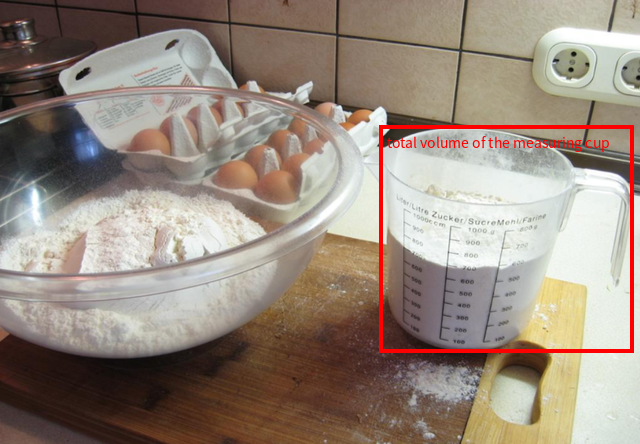

In [ ]:
image_path = "./data/1.png"


## Use a local HuggingFace model to inference.
# prompt in chinese
prompt = "框出每一个小蛋糕的位置，以json格式输出所有的坐标"
# prompt in english
prompt = "what is the total volume of the measuring cup?Please provide the bounding box coordinate of the region that can help you answer the question better and output all the coordinates in JSON format."
response, input_height, input_width = inference(image_path, prompt)

image = Image.open(image_path)
print(image.size)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image,response,input_width,input_height)

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
Look at the image and read the text below. Is there any sarcasm or irony present in the combination of the image and the text? Please provide the bounding box coordinate of the region that can help you answer the question better and output all the coordinates in JSON format.

Text: dump your furniture on the sidewalk & leave . the city of guelph will clean it up . of<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

output:
 ```json
[
	{"bbox_2d": [180, 376, 524, 770], "label": "sarcasm"}
]
```
(675, 1200)
(360, 640)


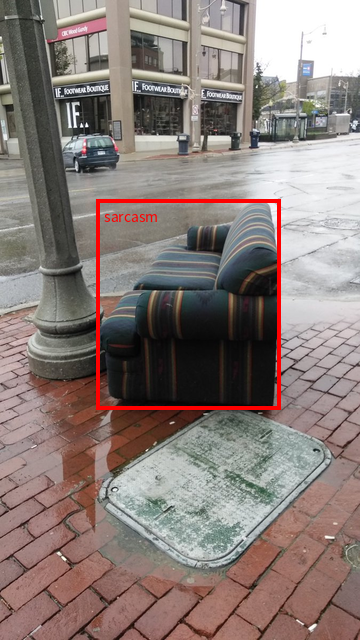

In [4]:
image_path = "/data/guojian.li/Dataset/MMSD/dataset_image/859056671179636737.jpg"

text = "dump your furniture on the sidewalk & leave . the city of guelph will clean it up . of"
prompt = (
        'Look at the image and read the text below. '
        'Is there any sarcasm or irony present in the combination of the image and the text? '
        'Please provide the bounding box coordinate of the region that can help you answer the question better and output all the coordinates in JSON format.\n\n'
        f'Text: {text}'
)
response, input_height, input_width = inference(image_path, prompt)

image = Image.open(image_path)
print(image.size)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image,response,input_width,input_height)